<a href="https://colab.research.google.com/github/jonbmartin/Gradient-Waveform-Errors-Demos/blob/main/Ex0_Characterization_Waveform_Design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Characterization Waveform Design

Welcome! Our first demo is simply concerned with generating gradient waveforms that are useful for gradient system characterization.

First, our imports...

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon

Next, two functions to help extract important information about our gradient waveform, and plot quantities of interest such as our slew rate. Both functions
are adapted from Brian Hargeaves's MATLAB implementations.

In [ ]:
def calcgradinfo(g, T=4e-6, k0=0, R=0.35, L=0.0014, eta=1/56):
    """
    Function calculates gradient information

    INPUT:
        g   gradient (G/cm) = gx + i*gy
        T   sample period (s) (default = 4e-6)
        k0  initial condition for k-space. (default = 0)
        R   coil resistance (ohms, default = 0.35)
        L   coil inductance (H, default = 0.0014)
        eta coil efficiency (G/cm/A, default = 1/56)

    OUTPUT:
        k   k-space trajectory (cm^(-1))
        g   gradient (G/cm)
        s   slew rate trajectory (G/cm/s)
        m1  first moment trajectory (s/cm)
        m2  second moment trajectory (s^2/cm)
        t   vector of time points (s)
        v   voltage across coil.

    #JBM TODO: Really just need to show kspace, gradient, slew for the purposes
    # here. could make an option that is default false

    Adapted from B.Hargreaves's MATLAB implementation from Aug 2002.
    """

    gamma = 4258  # Gamma (Gyromagnetic ratio in Hz/G)

    # Ensure g is a NumPy array
    g = np.asarray(g)

    # k-space trajectory
    k = k0 + np.cumsum(g, axis=0) * gamma * T

    # Time points
    # MATLAB's ([1:length(g)]-.5)*T can be replicated with arange and broadcasting
    if g.ndim == 1:
        lg = len(g)
    else:
        lg = g.shape[0]

    t = (np.arange(1, lg + 1) - 0.5) * T
    t = t.reshape(-1, 1)  # Ensure t is a column vector

    # Slew rate
    # MATLAB's [g; g(lg,:)]-[0*g(1,:); g]
    if g.ndim == 1:
        s_g_extended = np.concatenate((g, [g[lg-1]]))
        s_g_shifted = np.concatenate(([0], g))
    else:
        s_g_extended = np.concatenate((g, g[lg-1:lg, :]), axis=0)
        s_g_shifted = np.concatenate((np.zeros((1, g.shape[1])), g), axis=0)

    s = (s_g_extended - s_g_shifted)[1:] / T

    # First moment
    tt = t * np.ones((1, g.shape[1])) if g.ndim > 1 else t
    m1 = np.cumsum(g * tt, axis=0) * gamma * T

    # Second moment
    m2 = np.cumsum(g * (tt * tt + T**2 / 12), axis=0) * gamma * T

    # Voltage across coil
    v = (1 / eta) * (L * s + R * g)

    return k, g, s, m1, m2, t, v

In [ ]:
def plotgradinfo(g, T=4e-6, k0=0):
    """
    Function makes a nice plot given a single gradient waveform.

    INPUT:
        g   gradient (G/cm) = gx + i*gy, or Nx2, Nx3 or Nx4.
        T   sample period (s) (default = 4e-6)
        k0  initial condition for k-space. (default = 0)

    OUTPUT:
        k   k-space trajectory (cm^(-1))
        g   gradient (G/cm)
        s   slew rate trajectory (G/cm/s)
        m1  first moment trajectory (s/cm)
        m2  second moment trajectory (s^2/cm)
        t   vector of time points (s)
        v   voltage across coil.

    Adapted from B.Hargreaves's MATLAB implementation from Aug 2002.
    """

    gamma = 4258  # Gyromagnetic ratio in Hz/G

    g = np.asarray(g)

    # Handle complex input for g
    if g.ndim == 1 and np.iscomplex(g).any():
        g = np.column_stack((g.real, g.imag))

    # Calculate gradient information
    k, g_out, s, m1, m2, t, v = calcgradinfo(g, T, k0)

    sg = g_out.shape
    ng = sg[1]  # Number of columns in g

    acq = None
    if ng > 3:
        acq = g_out[:, 3]
        g_out = g_out[:, :3]
        k = k[:, :3]
        s = s[:, :3]
        m1 = m1[:, :3]
        m2 = m2[:, :3]
        v = v[:, :3]
        sg = g_out.shape
        ng = sg[1]

    # Plotting styles
    # MATLAB: pls={'g--','r--','b--','k:'}; pls{ng+1}='k:';
    # Python equivalent:
    pls = ['g--', 'r--', 'b--']
    pls_abs = 'k:' # Style for the magnitude plot

    M = 2
    N = 3
    plt.figure(figsize=(15, 10))
    plt.clf()

    if ng >= 2:
        plt.subplot(M, N, 1)
        if acq is not None and len(acq) > 0:
            # Replicate MATLAB's max(acq'.*sum((k(:,1:2))'.*(k(:,1:2))')))
            # This calculates the maximum squared magnitude of kx and ky during acquisition
            # And then takes the square root to get the max radius.

            # Find indices where acq is positive
            acq_indices = np.where(acq > 0)[0]

            if len(acq_indices) > 0:
                k_acq = k[acq_indices, :2]
                mxk = np.sqrt(np.max(np.sum(k_acq**2, axis=1)))

                theta = np.linspace(0, 2 * np.pi, 30)
                xsq = np.cos(theta) * mxk
                ysq = np.sin(theta) * mxk

                # Plot the acquisition circle as a shaded patch
                # MATLAB's patch(xsq,ysq,.8*[1 1 1]); set(h,'EdgeColor',.8*[1 1 1]);
                # In matplotlib, create a Polygon patch and add it to the axes
                patch_color = (0.8, 0.8, 0.8)
                patch = Polygon(np.column_stack((xsq, ysq)), closed=True, facecolor=patch_color, edgecolor=patch_color)
                plt.gca().add_patch(patch)

        plt.plot(k[:, 0], k[:, 1], 'b-')
        plt.xlabel('k_x (cm$^{-1}$)')
        plt.ylabel('k_y (cm$^{-1}$)')
        plt.title('K-space Trajectory')
        plt.grid(True)

        # Adjust axis limits to be symmetric around zero
        # MATLAB's a = axis; axis(max(abs(a))*[-1 1 -1 1]);
        current_xlim = plt.xlim()
        current_ylim = plt.ylim()
        max_abs_lim = max(abs(current_xlim[0]), abs(current_xlim[1]), abs(current_ylim[0]), abs(current_ylim[1]))
        plt.xlim([-max_abs_lim, max_abs_lim])
        plt.ylim([-max_abs_lim, max_abs_lim])
        plt.gca().set_aspect('equal', adjustable='box') # Ensure equal aspect ratio


    plt.subplot(M, N, 2)
    doplot(t * 1000, k, 'k', pls, pls_abs, acq) # Convert time to ms
    plt.xlabel('time (ms)')
    plt.ylabel('K-space (cm$^{-1}$)')
    plt.title('K-space vs time')

    plt.subplot(M, N, 3)
    doplot(t * 1000, g_out, 'g', pls, pls_abs, acq)
    plt.xlabel('time (ms)')
    plt.ylabel('Gradient (G/cm)')
    plt.title('Gradient vs time')

    plt.subplot(M, N, 4)
    doplot(t * 1000, s, 'slew', pls, pls_abs, acq)
    plt.xlabel('time (ms)')
    plt.ylabel('Slew Rate (G/cm/s)')
    plt.title('Slew Rates vs time')

    if M * N >= 5:
        plt.subplot(M, N, 5)
        doplot(t * 1000, m1, 'm1', pls, pls_abs, acq)
        plt.xlabel('time (ms)')
        plt.ylabel('First Moment (s/cm)')
        plt.title('First Moment vs time')

    # This part corresponds to the MATLAB's `if (0==0)` block, which means it always executes the first branch
    if M * N >= 6:
        plt.subplot(M, N, 6)
        doplot(t * 1000, m2, 'm2', pls, pls_abs, acq)
        plt.xlabel('time (ms)')
        plt.ylabel('Second Moment (s$^2$/cm)')
        plt.title('Second Moment vs time')

    plt.tight_layout() # Adjust subplot params for a tight layout
    plt.show()

    return k, g_out, s, m1, m2, t, v


def doplot(x, y, labs, col, col_abs, acq):
    """
    Helper function for plotting.
    x: time vector
    y: data to plot (k, g, s, m1, m2, or v)
    labs: string for legend label base (e.g., 'k', 'g')
    col: list of line styles for x, y, z components
    col_abs: line style for the absolute value
    acq: acquisition interval data
    """
    axl = ['x', 'y', 'z']
    ss = y.shape # Equivalent to MATLAB's size(y)

    # Handle acquisition interval shading
    if acq is not None and acq.size > 0:
        # Find start and end indices of acquisition
        mina_idx = np.where(acq > 0)[0]
        if len(mina_idx) > 0:
            mina = x[mina_idx[0]]
            maxa = x[mina_idx[-1]]

            xsq = [mina, maxa, maxa, mina]

            # Calculate ysq based on the max magnitude of y
            # MATLAB: ysq = 1.1*sqrt(max(abs(sum(y'.*y'))))*[-1 -1 1 1];
            # Sum of squares along rows, then sqrt to get magnitude for each time point
            mag_y = np.sqrt(np.sum(y**2, axis=1))
            max_mag_y = np.max(np.abs(mag_y))
            ysq = 1.1 * max_mag_y * np.array([-1, -1, 1, 1])

            patch_color = (0.8, 0.8, 0.8)
            patch = Polygon(np.column_stack((xsq, ysq)), closed=True, facecolor=patch_color, edgecolor=patch_color)
            plt.gca().add_patch(patch)


    leg = []
    for q in range(ss[1]): # Iterate through columns (x, y, z components)
        plt.plot(x, y[:, q], col[q % len(col)]) # Use modulo for cycling through colors
        leg.append(f'{labs}_{axl[q]}')

    if ss[1] > 1: # If there's more than one component (i.e., not a 1D gradient)
        # Calculate absolute value (magnitude) of the vector
        # MATLAB: ab = sqrt(sum(y.'.*y.')).';
        ab = np.sqrt(np.sum(y**2, axis=1))
        plt.plot(x, ab, col_abs)
        leg.append(f'|{labs}|')


    plt.legend(leg)
    plt.grid(True)

Ok, now let's actually design some gradient waveforms. The first thing we'd like to do is design a slew rate constrained chirp. This will allow us to
characterize the gradient system response across frequencies without violating hardware constraints.

In [ ]:

def chirp_slew_constrained(N, dt, G1, f1, f2, slr):
    """
    Calculates a slew-rate limited chirp waveform.

    This function is a Python conversion of the MATLAB function slrchirp.

    Reference:
    ----------
    Addy NO, Wu HH, Nishimura DG. Simple method for MR gradient system
    characterization and k-space trajectory estimation. Magn Reson Med.
    2012 Jul;68(1):120-9. doi: 10.1002/mrm.23217.

    Parameters:
    ----------
    N : int
        Number of points in the chirp.
    dt : float
        Timestep of each point (in ms).
    G1 : float
        Nominal maximum gradient amplitude (in G/cm).
    f1 : float
        Frequency at t=0 (in kHz).
    f2 : float
        Frequency at t=N*dt (in kHz).
    slr : float
        Slew rate limit (in G/cm/ms).

    Returns:
    -------
    chirp : numpy.ndarray
        The slew-rate limited chirp waveform.
    t : numpy.ndarray
        The time vector for the chirp (in ms).
    """
    # Total duration of the chirp
    T = N * dt

    # Create the time vector from 0 to (N-1)*dt
    t = np.arange(N) * dt

    # Instantaneous frequency at each time point (linear ramp)
    f = f1 + (f2 - f1) * t / T

    # Calculate the ideal chirp waveform
    # Phase of the chirp = 2*pi * integral(f(t) dt)
    phase = 2 * np.pi * (f1 * t + (f2 - f1) * t**2 / (2 * T))
    chirp = G1 * np.sin(phase)

    # Slew rate envelope of the ideal chirp
    # The slew rate is d(G)/dt, and its envelope is proportional to the
    # instantaneous frequency f.
    se = 2 * np.pi * G1 * f

    # Calculate the scaling factor based on the slew rate limit
    scaling_factor = np.minimum(slr / se, 1.0)

    # Apply the slew rate limit by scaling the chirp amplitude
    chirp = scaling_factor * chirp

    return chirp, t

Finally, let's just design a chirp and plot it, verifying that we do not violate slew rate constraints:

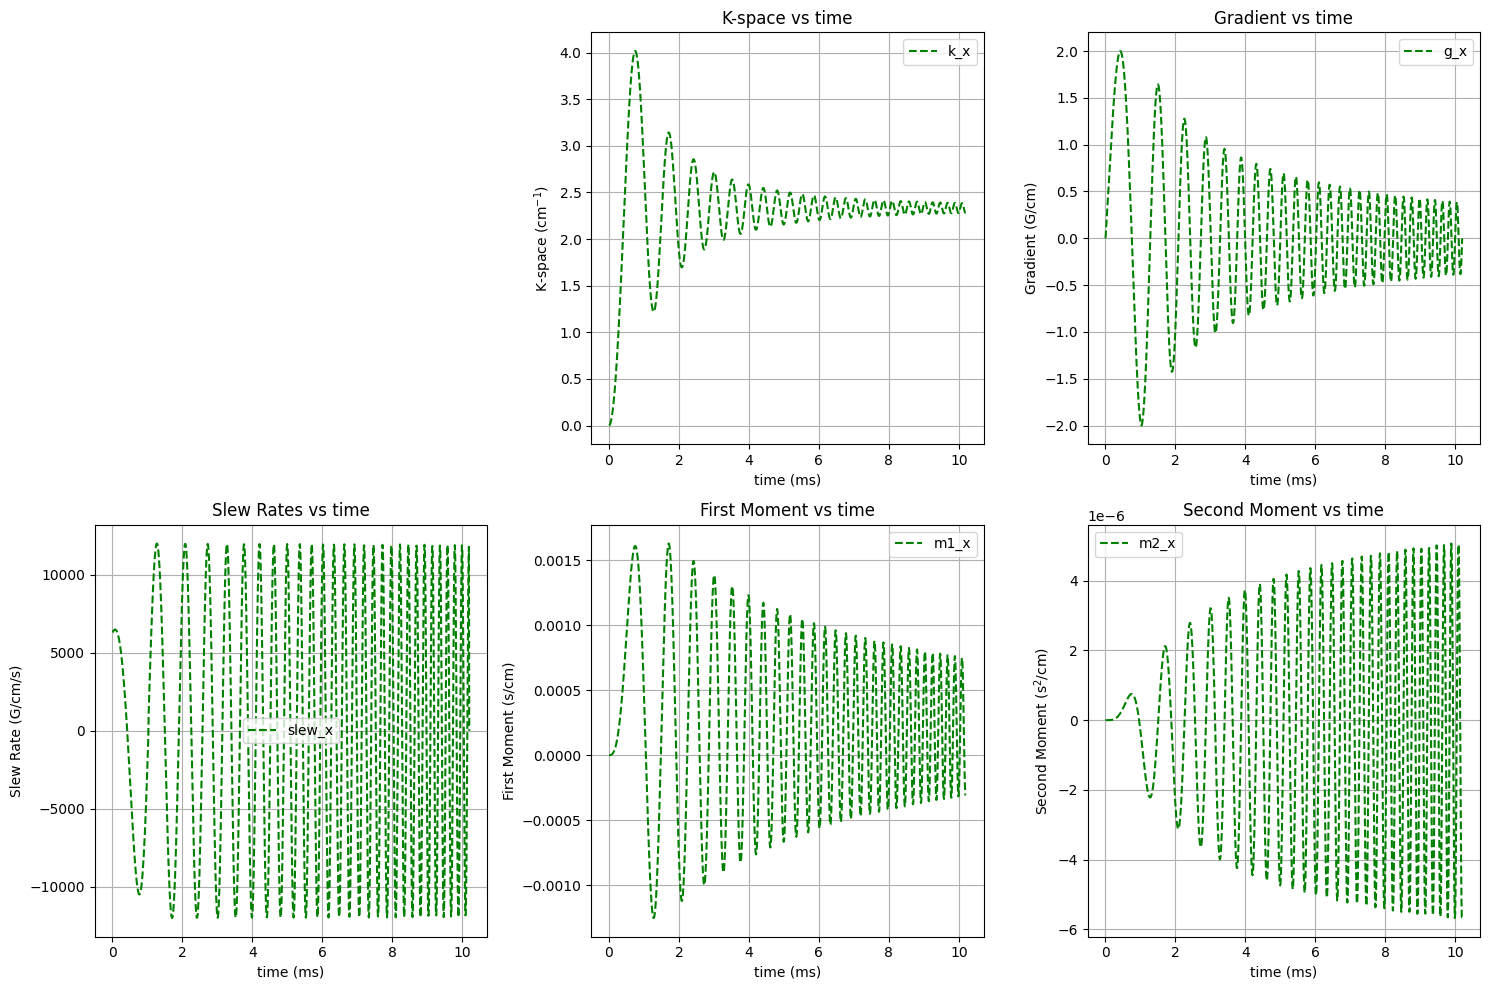

In [ ]:

# --- Define Chirp Parameters ---
N = 1020       # Number of points
dt = 0.01      # Timestep (ms) -> 10 ms total duration
G1 = 2        # Max gradient (G/cm)
f1 = 0.5       # Start frequency (kHz)
f2 = 5.0       # End frequency (kHz)
slr = 12      # Slew rate limit (G/cm/ms)

# --- Generate and Plot the Chirp ---
# We plot the slew rate to verify that we are indeed getting a slew-constrained
# chirp waveform.
chirp_waveform, time_vector = chirp_slew_constrained(N, dt, G1, f1, f2, slr)
chirp_waveform = chirp_waveform[:,None]
k, g_out, s, m1, m2, t, v = plotgradinfo(chirp_waveform, dt/1000)

Another common and useful waveform used for gradient system characterization is a triangle waveform sweep. Triangle waveforms offer the advantages of short duration relative to a chirp and high sensitivity to low-frequency response. Using multiple triangle lengths provides complementary information across the frequency domain.

In [ ]:
def triangle_sweeps(N, dt, G1, tmin, tmax, pad_dur=0.25, negative_triangles=True,
                    moment_null=False):
    """
    Produces a series of triangle waveforms with different lengths.

    Parameters:
    ----------
    N : int
        Number of triangle durations.
    dt : float
        Timestep of each point (in ms).
    G1 : float
        Nominal maximum gradient amplitude (in G/cm).
    tmin : float
        duration of minimum-length triangle (in ms).
    tmax : float
        duration of maximum-length triangle (in ms).
    pad_dur: float
        padding between triangles (in ms).
    negative_triangles: bool
        Whether to include a negative triangle.

    Returns:
    -------
    waveform : numpy.ndarray
        The slew-rate limited chirp waveform.
    t : numpy.ndarray
        The time vector for the chirp (in ms).
    """

    tri_durs = np.linspace(tmin, tmax, N)
    pad = np.zeros(int(pad_dur//dt))
    waveform = []

    for ii in range(N):
      triangle = np.concatenate((np.linspace(0,G1,int(tri_durs[ii]//dt//2)),np.linspace(G1,0,int(tri_durs[ii]//dt//2))))
      if negative_triangles:
        waveform = np.concatenate((waveform, pad, triangle, pad, -triangle))

      else:
        waveform = np.concatenate((waveform, pad, triangle))


    waveform = np.concatenate((waveform, pad))
    waveform = waveform[:,None]

    return waveform

In [ ]:
# --- Define Chirp Parameters ---
N = 5         # Number of triangles
dt = 0.01      # Timestep (ms)
G1 = 3        # Max gradient (G/cm)
tmin = 0.5     # Start duration (ms)
tmax = 3       # End duration (ms)

triangle_grad = triangle_sweeps(N, dt, G1, tmin, tmax, pad_dur=1, negative_triangles=True)
print(np.shape(triangle_grad))

(2825, 1)


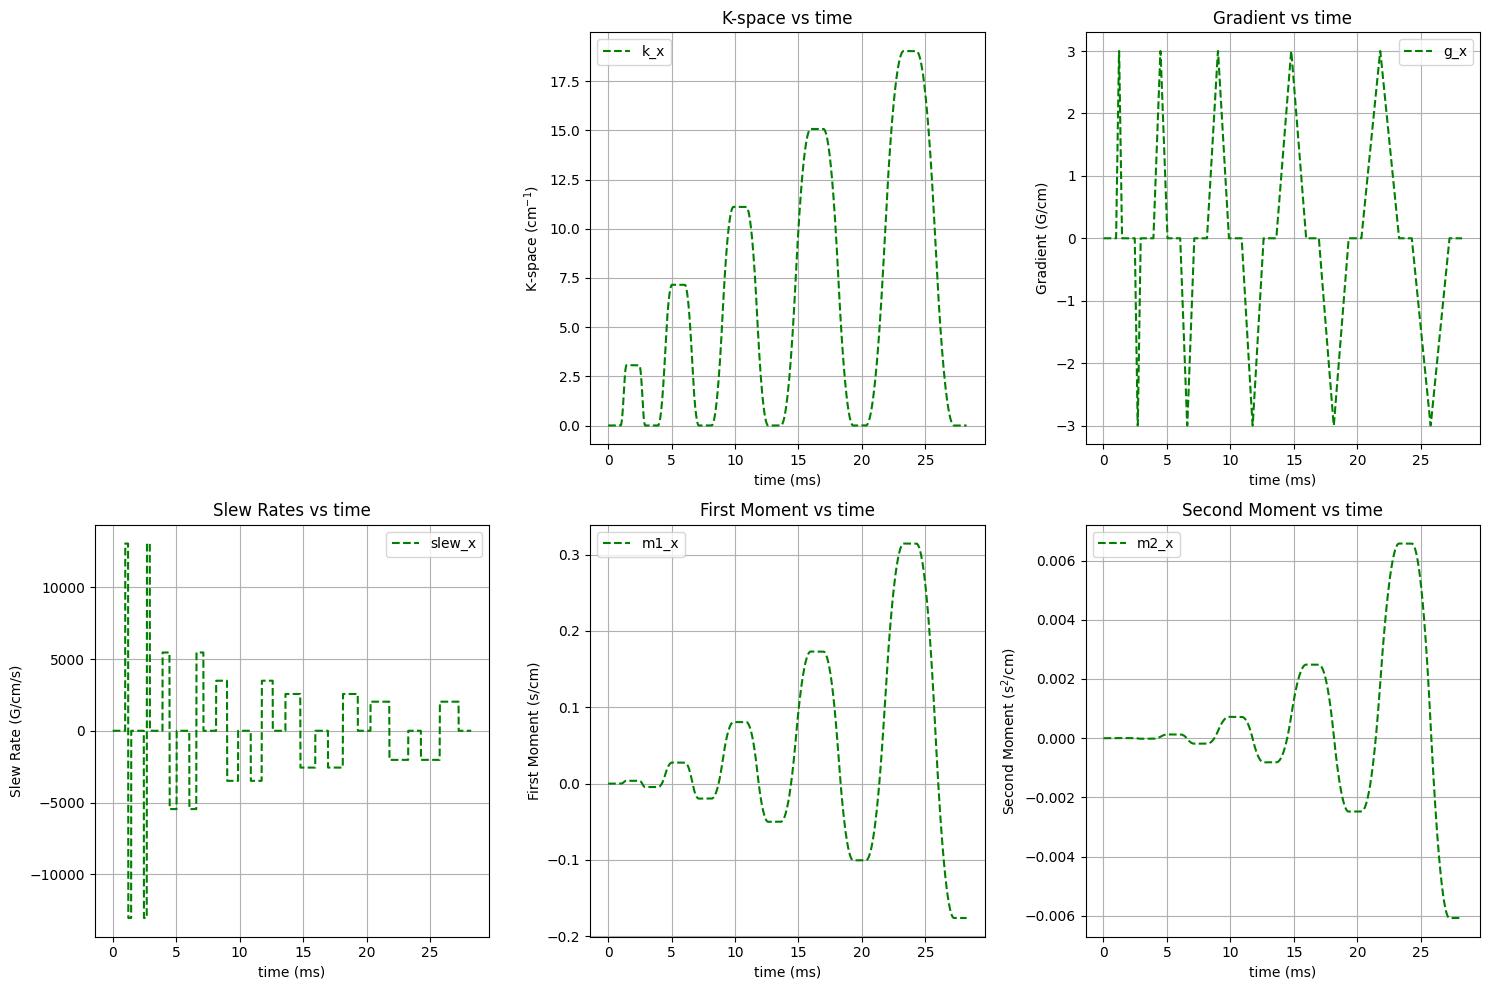

In [ ]:
k, g_out, s, m1, m2, t, v = plotgradinfo(triangle_grad, dt/1000)